In [1]:
import pandas as pd
import numpy as np
import json
import pymorphy2
import warnings
warnings.filterwarnings('ignore')
import enchant

## Шаг 0. Загрузка пакетов

В решении используется библиотека `enchant`. Она используется для проверки слов на спеллинг, и, как следствие, необходима для проверки слов на опечатки. Тем неменее, ее подгрузка и установка предполагает дополнительные хитрые действия. Чтобы библиотека подружилась с русским языком, в её структуру необходимо подгрузить два файла: ru_RU.aff, ru_RU.dic. [Например отсюда](https://github.com/LibreOffice/dictionaries/blob/master/ru_RU/ru_RU.dic). Эти файлы необходимо положить внутрь папок библиотеки к другим словарям, которые там уже есть. Для наглядности, можно посмотреть вот [сюда](https://vc.ru/dev/174452-kak-proverit-pravopisanie-s-pomoshch-python-pyenchant) Из этого следует, что решение доступно для запуска на локальном компьютере, но не на сервере (да, google colab, про тебя говорим), так как добраться до места хранения файлов в виртуальной машине проблематично.

В моем случае, файлы необходимо было вложить вот сюда: `C:\вставьте свою путь дальше, до папки, куда скачиваются библиотеки\enchant\data\mingw64\share\enchant\hunspell`

In [2]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

dictionary_big = enchant.Dict('ru_RU')

## Шаг 0.5. Подгружаем данные из задания

In [3]:
# Подгружаем данный в задании файл
with open('sample.json', 'r', encoding='UTF-8') as f:
    jj_list = json.load(f)
    
data = pd.DataFrame(columns = ['id', 'text'])

for js in jj_list:
    data = data.append(js, ignore_index = True)

## Шаг 0.7 Полезные функции

Создаем пайплайн обработки текстовых данных, чтобы на выходе получились тексты для алгоритмической работы с текстом и последующей кластеризации

In [4]:
"""
Функция для поиска имен собственных в тексте. Заметим, что здесь игнорируются те слова, которые начинают предложения/
Исходя из предположения, что в данных находятся несколько предложений, подвергшихся рерайтингу, и использованию в них
одних и тех же слов (в том числе имен собственных), исследовательская группа предполагает, что систематический неучет
слов, начинающих предложения, не будет существенным недочетом. Однако, можем отметить, что данное ограничение для модели
нуждается в более гибкой обработке и улучшении

"""

def find_names(TEXT_SERIES, names):
    all_names = set()
    for string in TEXT_SERIES.str.split(' '):
        names = [i for i in string if i[:1].isupper()]
        for n in names[1:]:
            all_names.add(morph.normal_forms(n.lower())[0])
    return all_names

In [5]:
def preprocessing_texts(df_PRACTISE):
    # Обрабатываем тексты
    df_PRACTISE['text'] = df_PRACTISE['text'].str.lower().replace('\n', ' ', regex = False).str.replace(r'[^\w\s\-]+', '', regex=True).str.strip()
    # Удаляем получившиеся полностью пустые комментарии, они нам все равно не помогут
    df_PRACTISE = df_PRACTISE[df_PRACTISE['text'].astype(bool) == True]
    # Удаляем пропуски в колонке тексте
    df_PRACTISE.dropna(subset=['text'], inplace=True)
    return df_PRACTISE

In [6]:
# Функция для создания нормализации слов, которые не являются именами собственными

def normalize(TEXT_SERIES):
    text_series = TEXT_SERIES
    i = 0
    for string in TEXT_SERIES.str.split(' '):
        clean_text = []
        for word in string:
            if (word not in all_names):
                word = morph.normal_forms(word)[0]
            clean_text.append(word)
        text = " ".join(x for x in clean_text)
        text_series.iloc[i] = text
        i = i + 1
    return text_series

In [7]:
"""
Функция для создания словаря тех слов, которые встречаются в данных.
Из словаря исключены слова собственные, так как они могут быть ошибочно причисленны к словам с опечатками
""" 

def create_dictionary(text_series, d):
    for string in text_series.str.split(' '):
        for word in string:
            if (word not in all_names):
                d.add(word)
    return d

## Шаг 1. Предобработка данных. Поиск и замена опечаток.

In [8]:
# Определяем тип предложения исходя из оканчивающего его знака препинания
data['type'] = data['text'].apply(lambda x: x[-1])

In [9]:
data = preprocessing_texts(data)

In [10]:
all_names = set()
all_names = find_names(data['text'], all_names)

In [11]:
data['norm_text'] = data['text'] #создание дополнительной колонки с текстом, состоящих из нормализованных слов
data['norm_text'] = normalize(data['norm_text'])

In [12]:
"""
Функция для подбора правильно написанных слов из словаря. Исследовательская группа посчитала, что сравнение со словарем,
созданном на основе исходных данных достаточно, так как слова с ошибками -- производные из существующих (и свидетельствуют
о наличии рерайтинга). Заметим, что в созданном словаре сейчас также находятся слова с ошибками.
Поэтому, при подборе правильного слово на место слова с опечаткой мы выбираем слово со вторым минимальным 
расстоняием Ливенштейна (справедливо, что это будет первое ненулевое значение в массиве).
"""
def top_levenshtain(word, dictionary):
    top = pd.DataFrame(columns = ['word_from_dict','lev_dist'])
    for w in dictionary:
        llev = enchant.utils.levenshtein(word, w)
        top = top.append({'word_from_dict' : w, 'lev_dist': llev}, ignore_index=True)
    top = top.sort_values(by=['lev_dist'])
    ww = top.iloc[1]['word_from_dict']
    return ww

In [13]:
# Замена слов с опечатками в исходных текстах. Заметим, что слова сразу заменяются на нормализированную форму
def change_words(TEXT_SERIES):
    text_series = TEXT_SERIES
    i = 0
    for string in TEXT_SERIES.str.split(' '):
        clean_text = []
        for word in string:
            if (word in mistakes and word not in all_names):
                word = correct[word]
            clean_text.append(word)
        text = " ".join(x for x in clean_text)
        text_series.iloc[i] = text
        i = i + 1
    return text_series

In [14]:
def detect_mistakes(data):
    dictionary = set()
    dictionary = create_dictionary(data['norm_text'], dictionary)
    
    # Создание списка слов с опечатками
    mistakes = []
    for i in dictionary:
        if not dictionary_big.check(i):
            mistakes.append(i)
            
    # Для удобного обращения, создаем хэш-таблицу, чтобы быстро заменять слова с опечаткой на корректное написнаие.
    correct = dict()
    for m in mistakes:
        ww = top_levenshtain(m, dictionary)
        correct[m] = ww
        
    return dictionary, mistakes, correct

In [15]:
dictionary, mistakes, correct = detect_mistakes(data)

data['text'] = change_words(data['text'])
data['norm_text'] = change_words(data['norm_text'])

### Слово об обработанном тексте

Дальнейшая работа с текстом будет происходить с помощью колонки `norm_text`. Несмотря на то, что 100% гарантии, что алгоритм отработал корректно нет, нам следует принять эти ограничения. Будем считать, что пока мы с машинами за одно.
![Мем в тему](http://memesmix.net/media/created/ucq1yp.jpg)

In [16]:
data

,id,text,type,norm_text
0,1,ты нашёл их или нет,?,ты найти они или нет
1,2,почему она так со мной поступает,?,почему она так с я поступать
2,3,никто туда больше не ходит,.,никто туда большой не ходить
3,4,у него с собой не было тогда денег,.,у он с себя не быть тогда деньга
4,5,почему они с нами так поступают,?,почему они с мы так поступать
...,...,...,...,...
407,408,рому было нечего сказать,.,рома быть нечего сказать
408,409,том ещё нас не видел,.,тот ещё мы не видеть
409,410,мы должны всем им помочь,.,мы должный весь они помочь
410,411,чего ты свой нос повсюду суёшь,?,что ты свой нос повсюду совать


Заметим, что из классического джентльменского набора предобработки текстов исключен этап удаления стоп-слов. Это было сделано по нескольким причинам. Во-первых, такие слова скорее будут свидетельствовать о схожести текстов между собой из-за специфики полученных в задании данных. Во-вторых, данные предложения достаточно короткие сами по себе, так что надобности сократить их ещё больше -- нет.

Другая проблема состоит в том, что в них достаточно много похожих слов, которые не входит в стоп-список, но будут встречаться в различных не связанных между собой предложениях. Это могут быть не стоп-слова, а более специфичные. Решим эту проблему на следующем шаге.

## Шаг 2. Частотность слов

In [ ]:
from collections import Counter

In [17]:
# Замена слов с опечатками в исходных текстах. Заметим, что слова сразу заменяются на нормализированную форму
def remove_common_words(TEXT_SERIES):
    text_series = TEXT_SERIES
    i = 0
    for string in TEXT_SERIES.str.split(' '):
        clean_text = []
        for word in string:
            if (word not in too_common):
                clean_text.append(word)
        text = " ".join(x for x in clean_text)
        text_series.iloc[i] = text
        i = i + 1
    return text_series

In [18]:
def makeSpecialData(data):
    mostcommon = data.most_common()
    special_data = pd.DataFrame({
        'Word': [element[0] for element in mostcommon],
        'Frequency': [element[1] for element in mostcommon]})
    return special_data

In [19]:
#Подсчитываем частоту слов
all_words = Counter()
for string in data['norm_text']:
    words = string.split(' ')
    words_count = Counter(words)
    all_words = all_words + words_count
    
# создаем из объекта counter датафрейм
table_all = makeSpecialData(all_words)

In [20]:
"""
Берем первых 5% самых частых слов с целью очищения данных от них. Это необходимо, чтобы кластеризация прошла лучше:
предложения, которые не являются рерайтингом, но имеющие общие слова будут объединяться в случайные кластеры
с меньшей вероятностью.

Количество этих слов варьируется. Предположительно: 
"""
red_line = round(0.05*len(table_all))
too_common = table_all.head(red_line)['Word'].to_list()

In [21]:
all_ = table_all['Frequency'].sum()
all_comm = table_all['Frequency'][:red_line].sum()

print(all_, all_comm, all_comm/all_)

2254 1088 0.48269742679680566


In [22]:
"""
Получаем текст, который подвергся следующей предобработке:
1. Нормализация
2. Замена опечаток
3. Удаление самых частых слов
"""

data['norm_text'] = remove_common_words(data['norm_text'])

In [23]:
"""
Получаем текст, который подвергся следующей предобработке:
1. Замена опечаток
2. Удаление самых частых слов
"""
data['unique_text'] = data['text']
data['unique_text'] = remove_common_words(data['unique_text'])

Исходный текст, который содержится в колонке `data['text']` -- текст, в котором опечатки заменены на корректные слова

## Шаг 2.5 TF-Idf

В ходе анализа были построены различные варианты матрицы `Tf-idf`. Тексты различались по степени обработки (см. выше). Также были построены матрицы `Tf-idf`, использующие только униграммы (или отдельные слова) и униграммы с биграммами. Исследовательской группой было принято решение оставить исключительно второй вариант (с униграммами и биграммами), так как рерайтинг часто подразумевает использование тех же слов, но в другом порядке. 

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AffinityPropagation

# Сделаем Tfidf матрицу по униграммам и биграммам
tfidf_vectorizer_bigrams = TfidfVectorizer(ngram_range=(1, 2))

# Применение TF-IDF к текстовым данным
tfidf_bi_text = tfidf_vectorizer_bigrams.fit_transform(data['text'].to_list())
tfidf_bi_norm = tfidf_vectorizer_bigrams.fit_transform(data['norm_text'].to_list())
tfidf_bi_unique = tfidf_vectorizer_bigrams.fit_transform(data['unique_text'].to_list())

In [25]:
tfidf_bi_text, tfidf_bi_norm, tfidf_bi_unique

(<412x1681 sparse matrix of type '<class 'numpy.float64'>'
 	with 3627 stored elements in Compressed Sparse Row format>,
 <412x882 sparse matrix of type '<class 'numpy.float64'>'
 	with 1857 stored elements in Compressed Sparse Row format>,
 <412x1453 sparse matrix of type '<class 'numpy.float64'>'
 	with 2779 stored elements in Compressed Sparse Row format>)

In [26]:
# Здесь похоронена попытка использовать AffinityPropagation

# af = AffinityPropagation(damping=0.9, max_iter=5000, 
#                          convergence_iter=2500,
#                          verbose=False, 
#                          random_state=1000).fit(tfidf_matrix_bi.toarray())

#  cluster_centers_indices = af.cluster_centers_indices_
# labels = af.labels_
# n_clusters_ = len(cluster_centers_indices)

# print("Estimated number of clusters: %d" % n_clusters_)

# print(cluster_centers_indices, labels)

# data['clust'] = pd.Series(labels) 

In [28]:
#!pip install --upgrade threadpoolctl

## Шаг 3. Кластеризация

Одна из самых сложный подзадач при задаче кластеризации -- это оптимальный подбор количества кластеров. Можно подбирать их на глаз, но мы постарались автоматизировать этот подход путем перебора и сравнения специальных метрик.
Подробные описнаия использованных метрик можно найти [здесь, но на R](https://uc-r.github.io/kmeans_clustering#:~:text=The%20average%20silhouette%20method%20computes,of%20possible%20values%20for%20k.2) и [здесь](https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

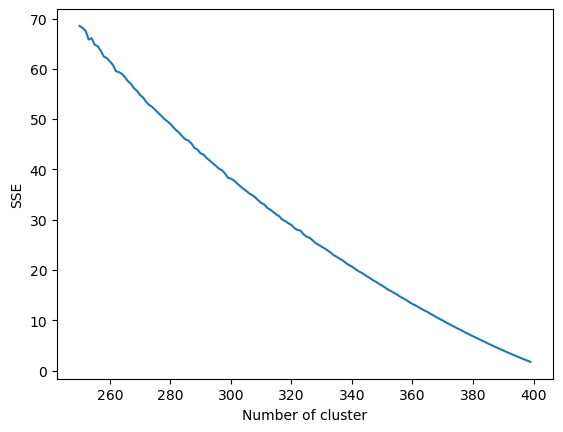

In [72]:
sse = {}
for k in range(250, 400):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=100).fit(tfidf_bi_text)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [90]:
silhouette_scores = pd.DataFrame(columns=['n_clusters', 'silhouette_score'])

for k in range(250, 400):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=100).fit(tfidf_bi_text)
    label = kmeans.labels_
    sil_coeff = silhouette_score(tfidf_bi_text, label, metric='euclidean')
    silhouette_scores = silhouette_scores.append({'n_clusters': k, 'silhouette_score': sil_coeff}, ignore_index = True)

In [91]:
silhouete_scores = silhouette_scores.sort_values(by='silhouette_score', ascending=False)
silhouete_scores.head(5)

,n_clusters,silhouette_score
3,253.0,0.211583
12,262.0,0.209637
0,250.0,0.209364
8,258.0,0.208512
5,255.0,0.208389


С помощью обоих метрик видим, что оптимальное количество кластеров равняется примерно 253 (на рисунке с `Elbow metrics` заметно колебание, которое выделяется на фоне плавной кривой, а также мера `silhouette_score` максимальна). Так как, у нас нет даже примерного представления о том, сколько кластеров в данных действительно есть, будем использовать полученное значение.


In [92]:
num_clusters = 253
kmeans = KMeans(n_clusters=num_clusters, max_iter=1000, random_state=100)

kmeans_text = kmeans.fit(tfidf_bi_text)

kmeans_norm = kmeans.fit(tfidf_bi_norm)
kmeans_unique = kmeans.fit(tfidf_bi_unique)

In [93]:
def create_data(kmeans_, data, num_clusters):
    dataF = pd.DataFrame(columns=["id", "text", "cluster_id"])
    dataF['id'] = data['id']
    dataF['text'] = data['text']
    dataF["cluster_id"] = 0
    
    for cluster_id in range(num_clusters):
        cluster_indices = np.where(kmeans_.labels_ == cluster_id)[0]
        for idx in cluster_indices:
            dataF["cluster_id"][idx] = cluster_id + 1
    dataF = dataF.sort_values(by='cluster_id')
    dataF = dataF.reset_index(drop=True)
    return dataF

In [94]:
kmeans_text_data =  create_data(kmeans_text, data, num_clusters)
kmeans_norm_data = create_data(kmeans_norm, data, num_clusters)
kmeans_unique_data = create_data(kmeans_unique, data, num_clusters)

In [98]:
kmeans_text_data.to_csv('kmeans_text_data.csv')

In [99]:
kmeans_norm_data.to_csv('kmeans_norm_data.csv')

In [100]:
kmeans_unique_data.to_csv('kmeans_unique_data.csv')

Таким образом, получены 3 списка кластеров.

## Куда улучшаться?

0. Разметить данные вручную для того, чтобы можно было проверить качество кластеризации
1. Более аккуратная замена опечаток
2. Использование другого алгоритма векоризации (например, `word2vec`)
3. Использование других кластеризирующих алгоритмов. Снова можно попробовать использовать `Affinity Propogation` и другие более продвинутые способы кластеризации